In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
print(sys.executable)

/home/raman-pc/miniconda3/bin/python


In [3]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [4]:
device = 'cuda'

In [5]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

torch.manual_seed(42)

from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [6]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [7]:
first_piece['timestamps'] = first_piece.index
first_piece

/tmp/ipykernel_868/4257701824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_piece['timestamps'] = first_piece.index


,O2_avg,timestamps
2017-07-11 14:00:00,244.479760,2017-07-11 14:00:00
2017-07-11 14:05:00,245.013691,2017-07-11 14:05:00
2017-07-11 14:10:00,246.106549,2017-07-11 14:10:00
2017-07-11 14:15:00,244.890977,2017-07-11 14:15:00
2017-07-11 14:20:00,244.949879,2017-07-11 14:20:00
...,...,...
2017-07-12 05:40:00,237.429344,2017-07-12 05:40:00
2017-07-12 05:45:00,237.754546,2017-07-12 05:45:00
2017-07-12 05:50:00,237.742503,2017-07-12 05:50:00
2017-07-12 05:55:00,237.609201,2017-07-12 05:55:00


In [8]:
ds_one = PandasDataset(dataframes=first_piece, freq='5min', target='O2_avg', timestamp='timestamps')

In [9]:
# training_data, test_gen = split(ds_one, offset=-36)
# test_data = test_gen.generate_instances(prediction_length=12, windows=3)

# # Train the model and make predictions
# model = DeepAREstimator(
#     prediction_length=12, freq="M", trainer_kwargs={"max_epochs": 5}
# ).train(training_data)

# forecasts = list(model.predict(test_data.input))

# # Plot predictions
# plt.plot(df["1954":], color="black")
# for forecast in forecasts:
#   forecast.plot()
# plt.legend(["True values"], loc="upper left", fontsize="xx-large")
# plt.show()

In [10]:
# def highlight_entry(entry, color):
#     start = entry["start"]
#     end = entry["start"] + len(entry["target"])
#     plt.axvspan(start, end, facecolor=color, alpha=0.2)


# def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
#     for original_entry, train_entry in zip(original_dataset, training_dataset):
#         original_entry.plot()
#         highlight_entry(train_entry, "red")
#         plt.legend(["sub dataset", "training dataset"], loc="upper left")
#         plt.show()

#     for original_entry in original_dataset:
#         for test_input, test_label in test_pairs:
#             original_entry.plot()
#             highlight_entry(test_input, "green")
#             highlight_entry(test_label, "blue")
#             plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
#             plt.show()

In [11]:
from gluonts.dataset.util import to_pandas

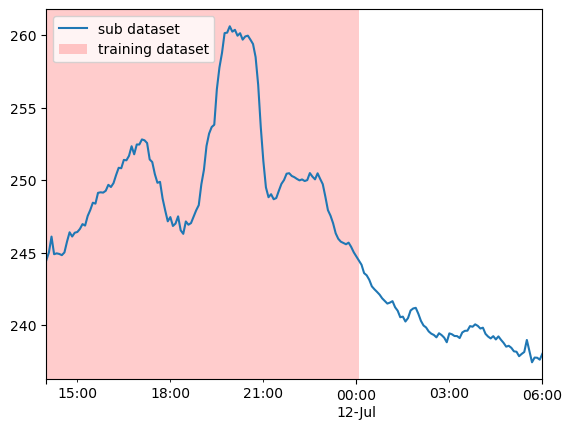

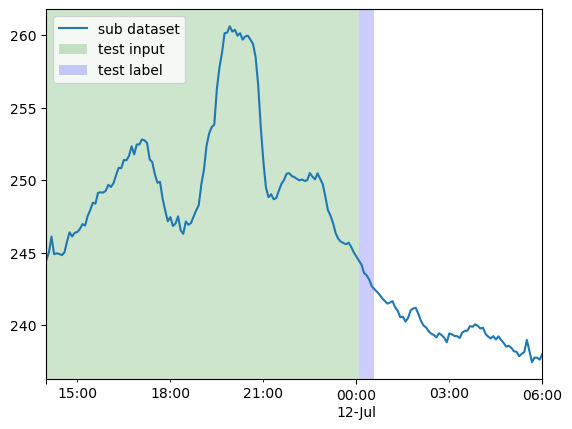

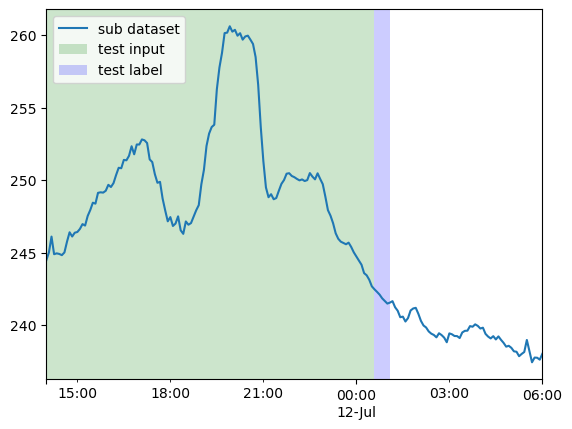

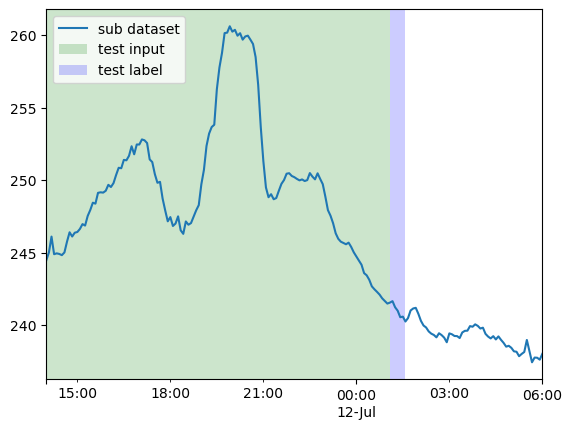

In [12]:
ds_one = PandasDataset(dataframes=first_piece, freq='5min', target='O2_avg', timestamp='timestamps')
def _to_datetime_index(s_or_df):
    obj = s_or_df.copy()
    if isinstance(obj.index, pd.PeriodIndex):
        obj.index = obj.index.to_timestamp()  # cast to DatetimeIndex
    return obj

def highlight_entry(entry, color):
    # entry["start"] is a pandas.Period, entry["target"] is an array-like
    start_period = entry["start"]
    n = int(len(entry["target"]))
    # left = start of the first period, right = start of the period AFTER the last step
    left = start_period.to_timestamp()
    right = (start_period + n).to_timestamp()
    plt.axvspan(left, right, facecolor=color, alpha=0.2)

def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(original_dataset, training_dataset):
        s = _to_datetime_index(to_pandas(original_entry))
        ax = s.plot()
        highlight_entry(train_entry, "red")
        ax.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in original_dataset:
        for test_input, test_label in test_pairs:
            s = _to_datetime_index(to_pandas(original_entry))
            ax = s.plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            ax.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()
            
prediction_length = 6 # Preditct next 30 minutes
training_dataset, test_template = split(
    ds_one, date=pd.Period("2017-07-12 00:00:00", freq="5min")
)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=3,
)

training_dataset
plot_dataset_splitting(ds_one, training_dataset, test_pairs)

In [13]:
estimator = DeepAREstimator(
    freq="5min",
    prediction_length=prediction_length,
    trainer_kwargs={"max_epochs": 50}
)

predictor = estimator.train(training_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/raman-pc/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-10-26 23:14:50.477430: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 23:14:50.484102: E 

Epoch 0: |          | 50/? [00:01<00:00, 32.69it/s, v_num=18, train_loss=5.990]

Epoch 0, global step 50: 'train_loss' reached 5.99346 (best 5.99346), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 38.73it/s, v_num=18, train_loss=3.690]

Epoch 1, global step 100: 'train_loss' reached 3.69395 (best 3.69395), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 37.09it/s, v_num=18, train_loss=3.110]

Epoch 2, global step 150: 'train_loss' reached 3.11006 (best 3.11006), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 38.43it/s, v_num=18, train_loss=2.980]

Epoch 3, global step 200: 'train_loss' reached 2.97994 (best 2.97994), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 38.98it/s, v_num=18, train_loss=2.940]

Epoch 4, global step 250: 'train_loss' reached 2.93802 (best 2.93802), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 37.40it/s, v_num=18, train_loss=2.620]

Epoch 5, global step 300: 'train_loss' reached 2.61781 (best 2.61781), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:01<00:00, 38.01it/s, v_num=18, train_loss=2.640]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 37.41it/s, v_num=18, train_loss=2.590]

Epoch 7, global step 400: 'train_loss' reached 2.59224 (best 2.59224), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:01<00:00, 37.35it/s, v_num=18, train_loss=2.550]

Epoch 8, global step 450: 'train_loss' reached 2.54945 (best 2.54945), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:01<00:00, 39.39it/s, v_num=18, train_loss=2.530]

Epoch 9, global step 500: 'train_loss' reached 2.53277 (best 2.53277), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:01<00:00, 38.22it/s, v_num=18, train_loss=2.520]

Epoch 10, global step 550: 'train_loss' reached 2.51660 (best 2.51660), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:02<00:00, 22.24it/s, v_num=18, train_loss=2.490]

Epoch 11, global step 600: 'train_loss' reached 2.49076 (best 2.49076), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:01<00:00, 38.48it/s, v_num=18, train_loss=2.510]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 37.34it/s, v_num=18, train_loss=2.520]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 35.26it/s, v_num=18, train_loss=2.480]

Epoch 14, global step 750: 'train_loss' reached 2.48290 (best 2.48290), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:01<00:00, 36.61it/s, v_num=18, train_loss=2.480]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 35.16it/s, v_num=18, train_loss=2.460]

Epoch 16, global step 850: 'train_loss' reached 2.45807 (best 2.45807), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:01<00:00, 33.36it/s, v_num=18, train_loss=2.490]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 35.24it/s, v_num=18, train_loss=2.450]

Epoch 18, global step 950: 'train_loss' reached 2.45406 (best 2.45406), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:01<00:00, 38.95it/s, v_num=18, train_loss=2.460]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 35.11it/s, v_num=18, train_loss=2.420]

Epoch 20, global step 1050: 'train_loss' reached 2.42304 (best 2.42304), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:01<00:00, 38.25it/s, v_num=18, train_loss=2.420]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 34.12it/s, v_num=18, train_loss=2.430]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 34.00it/s, v_num=18, train_loss=2.430]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 36.89it/s, v_num=18, train_loss=2.440]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 36.89it/s, v_num=18, train_loss=2.410]

Epoch 25, global step 1300: 'train_loss' reached 2.41136 (best 2.41136), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=25-step=1300.ckpt' as top 1


Epoch 26: |          | 50/? [00:01<00:00, 33.93it/s, v_num=18, train_loss=2.420]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 38.72it/s, v_num=18, train_loss=2.440]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 35.86it/s, v_num=18, train_loss=2.400]

Epoch 28, global step 1450: 'train_loss' reached 2.39909 (best 2.39909), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [00:01<00:00, 35.66it/s, v_num=18, train_loss=2.410]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 35.67it/s, v_num=18, train_loss=2.390]

Epoch 30, global step 1550: 'train_loss' reached 2.39464 (best 2.39464), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:01<00:00, 35.54it/s, v_num=18, train_loss=2.380]

Epoch 31, global step 1600: 'train_loss' reached 2.38313 (best 2.38313), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [00:01<00:00, 35.48it/s, v_num=18, train_loss=2.410]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 37.90it/s, v_num=18, train_loss=2.290]

Epoch 33, global step 1700: 'train_loss' reached 2.29346 (best 2.29346), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=33-step=1700.ckpt' as top 1


Epoch 34: |          | 50/? [00:02<00:00, 21.20it/s, v_num=18, train_loss=2.260]

Epoch 34, global step 1750: 'train_loss' reached 2.25959 (best 2.25959), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=34-step=1750.ckpt' as top 1


Epoch 35: |          | 50/? [00:01<00:00, 38.23it/s, v_num=18, train_loss=2.260]

Epoch 35, global step 1800: 'train_loss' reached 2.25840 (best 2.25840), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=35-step=1800.ckpt' as top 1


Epoch 36: |          | 50/? [00:01<00:00, 34.75it/s, v_num=18, train_loss=2.840]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 38.27it/s, v_num=18, train_loss=2.660]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 40.36it/s, v_num=18, train_loss=2.520]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 40.92it/s, v_num=18, train_loss=2.350]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 38.48it/s, v_num=18, train_loss=2.310]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 34.63it/s, v_num=18, train_loss=2.780]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 33.81it/s, v_num=18, train_loss=2.880]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 32.05it/s, v_num=18, train_loss=2.790]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 38.54it/s, v_num=18, train_loss=2.770]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 38.75it/s, v_num=18, train_loss=2.760]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 39.13it/s, v_num=18, train_loss=2.740]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 38.37it/s, v_num=18, train_loss=2.290]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 36.34it/s, v_num=18, train_loss=2.180]

Epoch 48, global step 2450: 'train_loss' reached 2.18298 (best 2.18298), saving model to '/home/raman-pc/smores_proj/src/single_step/lightning_logs/version_18/checkpoints/epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:01<00:00, 38.46it/s, v_num=18, train_loss=2.350]

Epoch 49, global step 2500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:01<00:00, 38.39it/s, v_num=18, train_loss=2.350]


In [14]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
first_pair = next(iter(test_pairs))
second_pair = next(iter(test_pairs))
third_pair = next(iter(test_pairs))

forecast_it, ts_it = make_evaluation_predictions(
    dataset=first_pair,      # pass the TestData as-is
    predictor=predictor,
)

forecasts = list(forecast_it)   # materialize generators
labels   = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(labels, forecasts)


Running evaluation: 2it [00:00, 47.02it/s]
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:108: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:157: RuntimeWarning: divide by zero encountered in divide
  return numerator / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  ret

In [24]:
forecast_it

<generator object PyTorchPredictor.predict at 0x7f116df58840>

/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


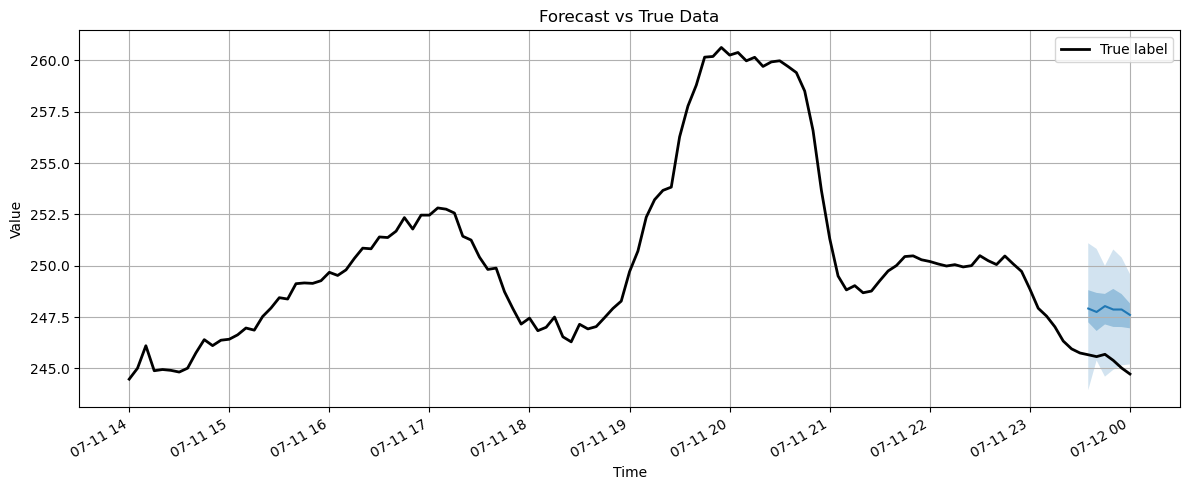

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Select forecast and label
fcst = forecasts[0]
label = labels[0]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


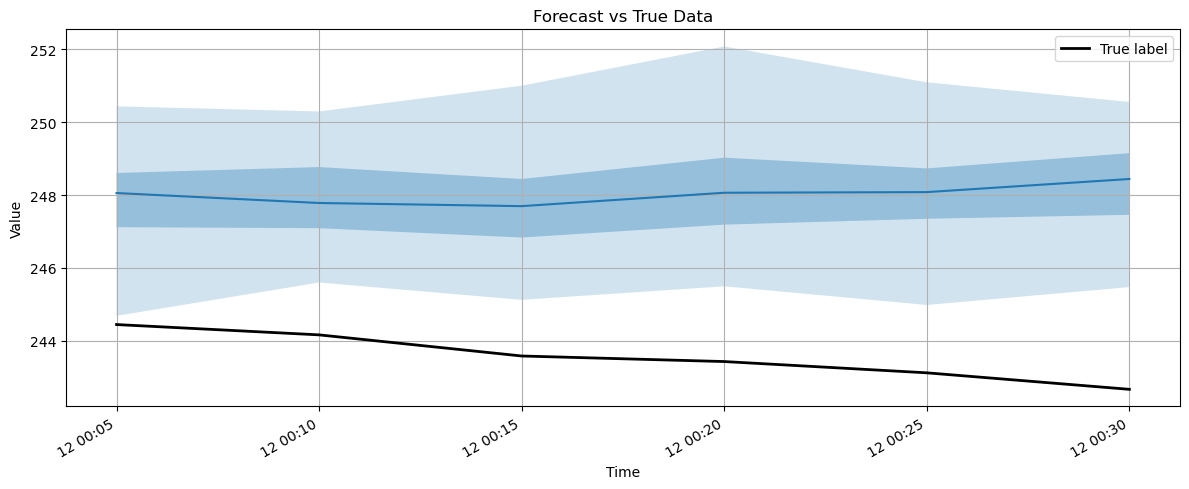

In [18]:
# Select forecast and label
fcst = forecasts[1]
label = labels[1]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


Running evaluation: 2it [00:00, 56.32it/s]
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:108: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:157: RuntimeWarning: divide by zero encountered in divide
  return numerator / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  ret

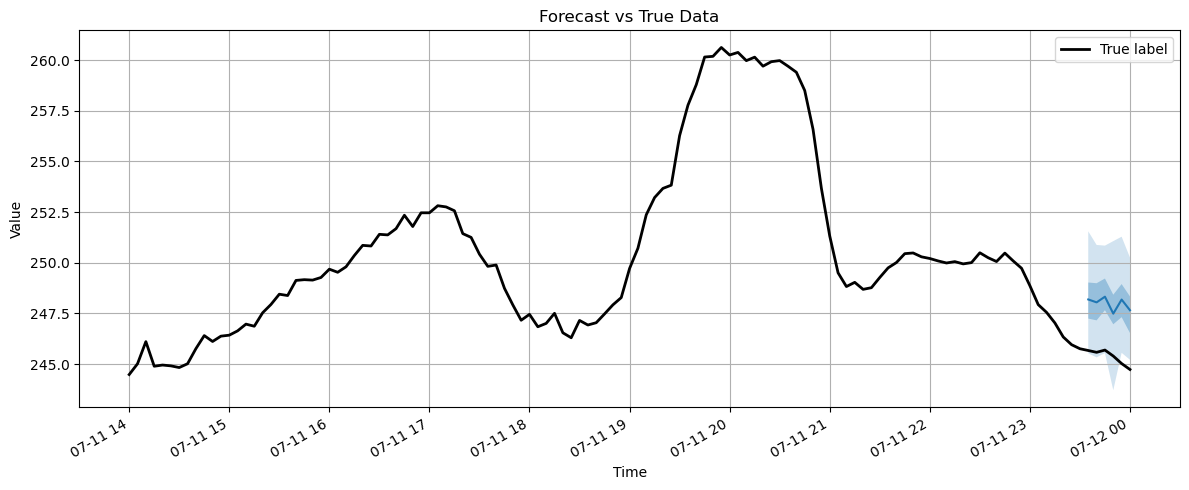

In [19]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=second_pair,      # pass the TestData as-is
    predictor=predictor,
)

forecasts = list(forecast_it)   # materialize generators
labels   = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(labels, forecasts)

# Select forecast and label
fcst = forecasts[0]
label = labels[0]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


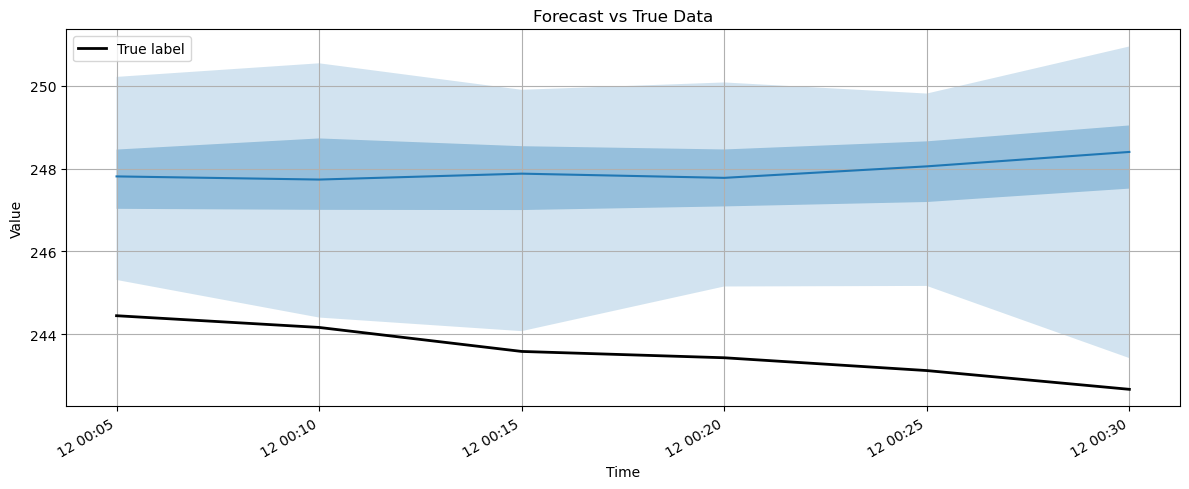

In [20]:
fcst = forecasts[1]
label = labels[1]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

Running evaluation: 2it [00:00, 53.20it/s]
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:108: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/gluonts/evaluation/metrics.py:157: RuntimeWarning: divide by zero encountered in divide
  return numerator / seasonal_error
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  ret

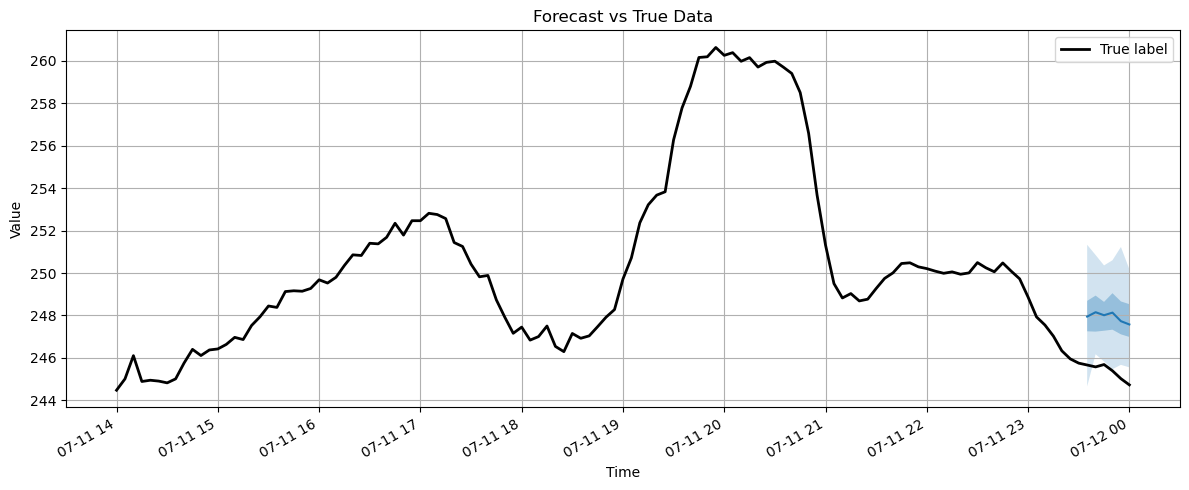

In [21]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=third_pair,      # pass the TestData as-is
    predictor=predictor,
)

forecasts = list(forecast_it)   # materialize generators
labels   = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(labels, forecasts)

# Select forecast and label
fcst = forecasts[0]
label = labels[0]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


/home/raman-pc/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


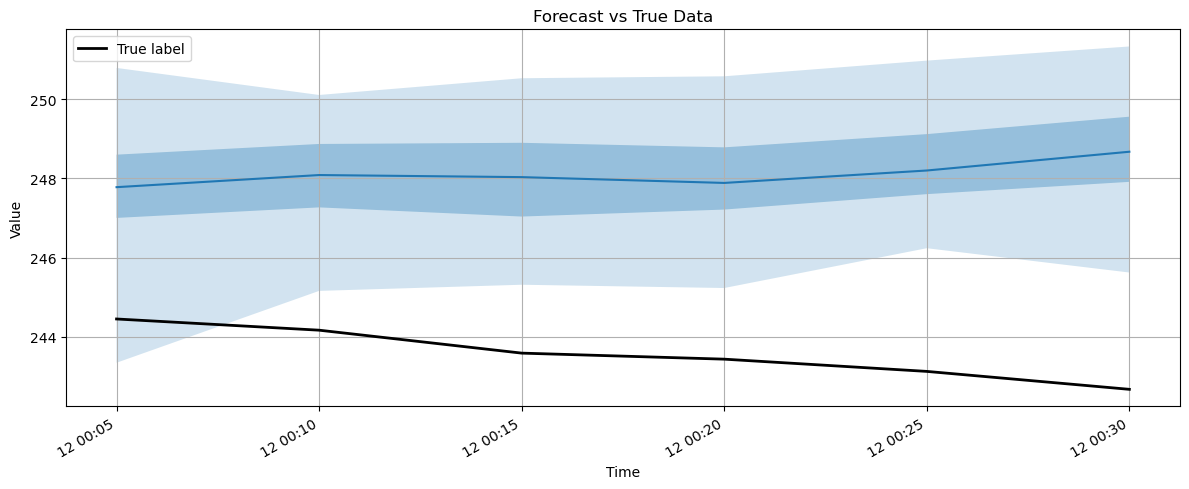

In [22]:
fcst = forecasts[1]
label = labels[1]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()